In [1]:
from itertools import product, combinations
import numpy as np
import networkx as nx
from icecream import ic
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import os
import re

In [2]:
def create_problem(
    size: int,
    *,
    density: float = 1.0,
    negative_values: bool = False,
    noise_level: float = 0.0,
    seed: int = 42,
) -> np.ndarray:
    """Problem generator for Lab3"""
    rng = np.random.default_rng(seed)
    map = rng.random(size=(size, 2))
    problem = rng.random((size, size))
    if negative_values:
        problem = problem * 2 - 1
    problem *= noise_level
    for a, b in product(range(size), repeat=2):
        if rng.random() < density:
            problem[a, b] += np.sqrt(
                np.square(map[a, 0] - map[b, 0]) + np.square(map[a, 1] - map[b, 1])
            )
        else:
            problem[a, b] = np.inf
    np.fill_diagonal(problem, 0)
    return (problem * 1_000).round()

Upload one or more notebooks with the Shortest Path between two cities (if it exists and if it is positive).

In [3]:
sizes = [10, 20, 50, 100, 200, 500, 1_000]
densities = [.2, .5, .8, 1.0]
noise_levels = [.0, .1, .5, .8]
negative_values_options = [False, True]

Adopted strategy, given a fraction $r$ and a graph $\mathcal{G}=(\mathcal{V},\, \mathcal{E},\, W)$
1. Randomly select a set $\mathcal{L}$ of landmarks, $\lvert\mathcal{L}\rvert = \lceil r\lvert \mathcal{V}\rvert \rceil$;
2. Compute shortest path to all nodes from landmarks using the Bellman-Ford algorithm;
3. Compute shortest path from all nodes to landmarks using the Bellman-Ford algorithm on the reversed graph $\tilde{\mathcal{G}}$;
4. Estimate the shortest path for remaining nodes considering the landmark $l$
   $$
   \argmin_{l\in\mathcal{L}}\ \text{weight}(\Gamma_{u,\,l}) + \text{weight}(\Gamma_{l,\,v})
   $$
   where $\Gamma_{u,\,l}$ is the shortest path from $u$ to $l$ and $\Gamma_{l,\,v}$ is the shortest path from $l$ to $v$;
   the estimated shortest path is the concatenation of $\Gamma_{u,\,l}$ and $\Gamma_{l,\,v}$ and its weight is 
   $$
   \text{weight}(\Gamma_{u,\,l}) + \text{weight}(\Gamma_{l,\,v}).
   $$
In the case where we have graphs with negative edge weights, while computing paths from and to landmarks we set the distance to $+\infty$ if the cost of the path is negative.
We don't try to find a minimum path satisfying the constraint that the path must be positive since it is a NP-hard problem and it does not scale well for large $\lvert\mathcal{V}\rvert$.

In [4]:
def solve_approximate(G: nx.DiGraph, landmark_fraction: float, only_positive :bool = False) -> np.ndarray:
    reversed_G = G.reverse(copy=True)
    N = G.number_of_nodes()
    N_landmarks = int(landmark_fraction * N)
    landmarks = np.random.choice(N, size=N_landmarks, replace=False).tolist()

    approx_distances = np.zeros((N, N)) + np.inf
    from_landmark = np.zeros((N_landmarks, N)) + np.inf
    to_landmark = np.zeros((N_landmarks, N)) + np.inf

    for i, lm in enumerate(landmarks):
        try:
            length, path = nx.single_source_bellman_ford(G, lm, weight='weight')
            for node, dist in length.items():
                approx_distances[lm, node] = dist
                from_landmark[i, node] = dist
            length, path = nx.single_source_bellman_ford(reversed_G, lm, weight='weight')
            for node, dist in length.items():
                to_landmark[i, node] = dist
        except nx.NetworkXUnbounded:
            # Negative cycle detected
            continue
    
    if only_positive:
        to_landmark[to_landmark < 0] = np.inf
        from_landmark[from_landmark < 0] = np.inf
        approx_distances[approx_distances < 0] = np.inf

    for source in range(N):
        for dest in range(N):
            if source == dest or not np.isinf(approx_distances[source, dest]):
                continue
            distances = to_landmark[:, source] + from_landmark[:, dest]
            approx_distances[source, dest] = np.min(distances)
    np.fill_diagonal(approx_distances, np.inf)
    return approx_distances

In the case $\lvert\mathcal{V}\rvert = 100$, the following algorithm will be used to compare the performance of our heuristic with the exact algorithm.
This is not viable for larger values of $\lvert\mathcal{V}\rvert$.

In [5]:
def solve_exact(G: nx.DiGraph, only_positive: bool = False) -> np.ndarray:
    N = G.number_of_nodes()
    all_distances = np.zeros((N, N)) + np.inf
    for s, d in product(range(N), repeat=2):
        if s == d:
            continue
        try:
            # path = nx.shortest_path(G, s, d, weight='weight')
            path = nx.bellman_ford_path(G, s, d, weight='weight')
            cost = cost = nx.path_weight(G, path, weight='weight')
        except nx.NetworkXNoPath:
            # Nodes are not connected
            path = None
            cost = np.inf
        except nx.NetworkXUnbounded:
            # Negative cycle detected
            path = None
            cost = -np.inf
        if only_positive and cost < 0:
            cost = np.inf
        all_distances[s, d] = cost
    return all_distances

Since the results take a lot of time to compute, store them using `pickle`.
For convenience, I saved results of the heuristic in the `results` folder: you can avoid running the following cell.

In [ ]:
iterator = product(sizes, densities, noise_levels, negative_values_options)
iterator_size = len(sizes)*len(densities)*len(noise_levels)*len(negative_values_options)
results = {}
for size, density, noise_level, negative_values in tqdm(iterator, total=iterator_size):
    ic(size, density, noise_level, negative_values)
    problem = create_problem(
        size,
        density=density,
        noise_level=noise_level,
        negative_values=negative_values,
        seed=42,
    )
    masked = np.ma.masked_array(problem, mask=np.isinf(problem))
    G = nx.from_numpy_array(masked, create_using=nx.DiGraph)
    approximate_distances = solve_approximate(G, landmark_fraction=0.1, only_positive=negative_values)
    results[(size, density, noise_level, negative_values)] = approximate_distances

os.mkdir("results")
iterator = product(sizes, densities, noise_levels, negative_values_options)
for t in tqdm(iterator, total=iterator_size):
    with open(f"results/result_size{t[0]}_density{t[1]}_noise{t[2]}_neg{t[3]}.pkl", "wb") as f:
        pickle.dump(results[t], f)

On the contrary, run this cell to load results from the folder!

In [6]:
pkl_files = os.listdir("results")
all_results = {}
pattern = r"result_size(?P<size>\d+)_density(?P<density>[\d\.]+)_noise(?P<noise>[\d\.]+)_neg(?P<neg>True|False)\.pkl"

for file in pkl_files:
    match = re.match(pattern, file)
    if match:
        size = int(match.group("size"))
        density = float(match.group("density"))
        noise = float(match.group("noise"))
        neg = match.group("neg") == "True"
        with open(os.path.join("results", file), "rb") as f:
            data = pickle.load(f)
        all_results[(size, density, noise, neg)] = data

To assess performance we compute mean absolute error with respect to the shortest path length in the case $\lvert \mathcal{V} \rvert = 100$.
It takes a bit, so for convenience I saved the results in a csv file.

In [ ]:
test_df = pd.DataFrame(all_results.keys(), columns=["size", "density", "noise", "neg"])
test_df = test_df.loc[test_df['size'] == 100]
exact_dists = []

for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    dict_key = tuple(row)
    print(dict_key)
    problem = create_problem(
        dict_key[0],
        density=dict_key[1],
        noise_level=dict_key[2],
        negative_values=dict_key[3]
    )
    masked = np.ma.masked_array(problem, mask=np.isinf(problem))
    G = nx.from_numpy_array(masked, create_using=nx.DiGraph)
    exact_distances = solve_exact(G, only_positive=dict_key[3])
    exact_dists.append(exact_distances)

# Compute mean absolute differences
mean_diff = []
for i in range(len(test_df)):
    est = all_results[tuple(test_df.iloc[i])]
    exact = exact_dists[i]
    diff = est[np.isfinite(exact)] - exact[np.isfinite(exact)]
    mean_diff.append(np.mean(np.abs(diff)))
mean_diff = np.array(mean_diff)

# Add mean absolute difference to dataframe
test_df["mean_abs_diff"] = mean_diff
# Drop rows with NaN values, associated to problems with negative cycles
test_df = test_df.dropna()
# Save the cleaned dataframe to a CSV file
test_df.to_csv("mean_absolute_differences.csv", index=False)

Run this cell to load MAE data without running the code above.
Notice that some data for `neg = True` is missing due to negative cycles being present in the graphs, from all sources to all destinations.

In [7]:
test_df = pd.read_csv("mean_absolute_differences.csv")
test_df

,size,density,noise,neg,mean_abs_diff
0,100,0.2,0.0,False,141.836364
1,100,0.2,0.0,True,122.209697
2,100,0.2,0.1,False,213.828990
3,100,0.2,0.1,True,134.479021
4,100,0.2,0.5,False,368.204747
5,100,0.2,0.8,False,447.181919
6,100,0.5,0.0,False,81.182525
7,100,0.5,0.0,True,80.354040
8,100,0.5,0.1,False,109.712222
9,100,0.5,0.5,False,236.227576


Let's now analyze results, better results could be obtained increasing the number of landmarks computed.

For a given density, MAE is pretty low and grows with the value of noise, probably due to edge weights being larger.

<Axes: title={'center': 'Mean Absolute Error (negative weights)'}, xlabel='noise', ylabel='mean_abs_diff'>

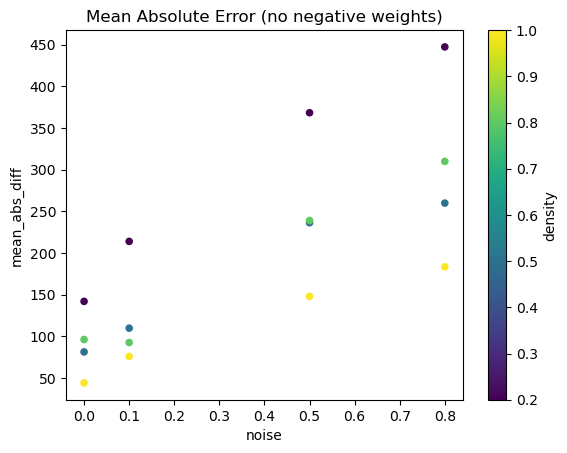

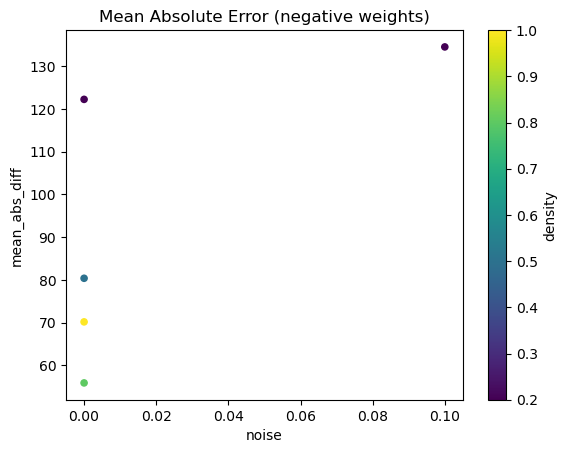

In [8]:
test_df.loc[~test_df.neg].plot.scatter(x="noise", y="mean_abs_diff", c="density", colormap="viridis", title="Mean Absolute Error (no negative weights)")
test_df.loc[test_df.neg].plot.scatter(x="noise", y="mean_abs_diff", c="density", colormap="viridis", title="Mean Absolute Error (negative weights)")

For a given noise level, MAE decreases as density increases due to shorter paths being present.
This is good since it means that we can effectively find shorter paths as density increases.
Notice that for denser graphs, landmark computation takes more time.

<Axes: title={'center': 'Mean Absolute Error (negative weights)'}, xlabel='density', ylabel='mean_abs_diff'>

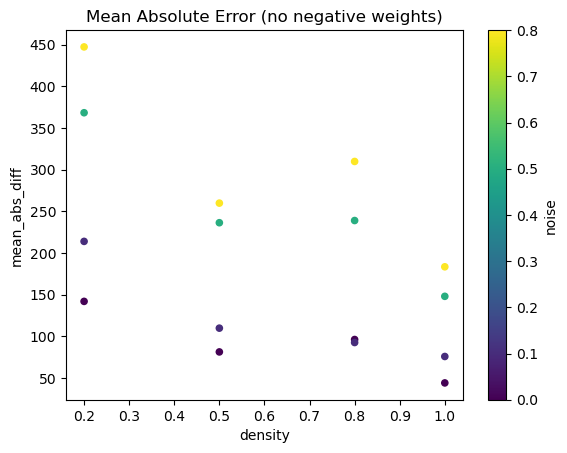

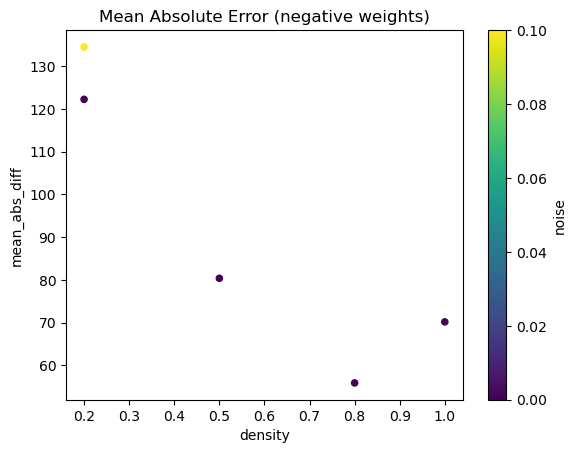

In [9]:
test_df.loc[~test_df.neg].plot.scatter(x="density", y="mean_abs_diff", c="noise", colormap="viridis", title="Mean Absolute Error (no negative weights)")
test_df.loc[test_df.neg].plot.scatter(x="density", y="mean_abs_diff", c="noise", colormap="viridis", title="Mean Absolute Error (negative weights)")